In [99]:
from syft import Linear, Sigmoid, Model
import syft.syft as syft
import imp
imp.reload(syft)
import numpy as np
from syft.syft import FloatTensor,SyftController
# connect -- rerun this block if you make changes to the unity back-end
#         -- the controller is not yet smart enough to retry connection
#         -- on its own
sc = SyftController(verbose=False)

# MNIST

This is a stipped down version of MNIST.  We will learn how to recognize a 6!

For this demo to work you'll need to download the mnist dataset from [here](http://yann.lecun.com/exdb/mnist/)
and place them in `notebooks/data/`


In [262]:
## Helper function to read the MNIST data set

import os
import struct
import numpy as np

"""
Loosely inspired by http://abel.ee.ucla.edu/cvxopt/_downloads/mnist.py
which is GPL licensed.
"""

def read(dataset = "training", path = "./data"):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """

    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        tmp = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)
        tmp2 = np.array(tmp).astype('float')
        img = [ x / 255 for x in tmp2 ]
        

    get_img = lambda idx: (lbl[idx], img[idx])

    # Create an iterator which returns each image in turn
    for i in range(len(lbl)):
        yield get_img(i)

def show(image):
    """
    Render a given numpy.uint8 2D array of pixel data.
    """
    from matplotlib import pyplot
    import matplotlib as mpl
    fig = pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    pyplot.show()

We are going to train and get really good at recognizing this 6

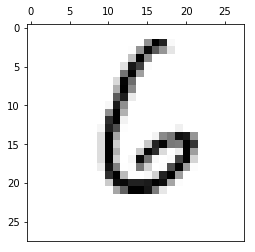

In [263]:
data = read()
label, pixels = list(data)[32] ## random 6 i found
show(pixels)

In [247]:
from syft import Linear, Sigmoid, Model
import syft.syft as syft
import imp
imp.reload(syft)
import numpy as np
from syft.syft import FloatTensor,SyftController
# connect -- rerun this block if you make changes to the unity back-end
#         -- the controller is not yet smart enough to retry connection
#         -- on its own
sc = SyftController(verbose=False)

Our data

In [258]:
input = sc.FloatTensor(pixels).view(1, 28*28).autograd(True)
target = sc.FloatTensor([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]]).autograd(True)

Our model

In [249]:
class MNIST(Model):
    def __init__(self, input=784, hidden=15, output=10):
        
        # Weights
        self.weights_0 = sc.Linear(input,hidden)
        self.weights_1 = sc.Linear(hidden,output)

        self.sigmoid = sc.Sigmoid()
        
    def forward(self, input):
                
        layer_1 = self.sigmoid(self.weights_0(input))
        # print("layer 1 grad {}".format(layer_1.grad))
        layer_2 = self.sigmoid(self.weights_1(layer_1))
        # print("layer 2 grad {}".format(layer_2.grad))
        
        return layer_2

In [250]:
model = MNIST()

Train our model to become a pro at that 6

In [264]:
for iter in range(100):

    pred = model(input)

    loss = (pred - target) ** 2 # Mean Squared Error Loss

    loss.backward()

    for p in model.parameters():
        p.weights -= p.weights.grad().T()

Now, let's find a different 6 in the data and see how well we can recognize that

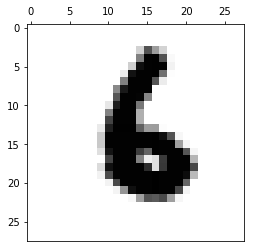

In [267]:
data = read()
label, pixels = list(data)[36] ## a different random 6 i found
show(pixels)
other_six = sc.FloatTensor(pixels).view(1, 28*28).autograd(True)

In [268]:
pred = model(other_six)
pred

[[  5.67945800e-35   4.52078000e-33   8.05778400e-39   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.00000000e+00   1.40129800e-45
    2.52381000e-38   1.40129800e-45]]
[syft.FloatTensor of size 1x10]

check out the 6th element of the array!

## Exercises!

Can you extend the training process to get good at learning any number?